# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [3]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
import torch

import numpy as np

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for a days in period 2011-01-01 to 2019-12-31 (9 years);

In [5]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [6]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2019-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (22330, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265025,576145,ABEV3.SA,0
1,2011-01-03,31.500000,31.799999,31.379999,13.565921,3313400,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.708654,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.446316,10014663,ITUB4.SA,0
4,2011-01-03,9.264964,9.492898,9.264964,7.048942,3320493,LREN3.SA,0
...,...,...,...,...,...,...,...,...
22325,2019-12-30,30.549999,30.709999,30.150000,11.107358,22111600,PETR4.SA,0
22326,2019-12-30,6.780000,6.832000,6.570000,6.601397,8933500,PRIO3.SA,0
22327,2019-12-30,47.959999,48.290001,47.299999,44.469742,2701600,RENT3.SA,0
22328,2019-12-30,53.650002,53.860001,53.200001,37.320976,11928100,VALE3.SA,0


In [7]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2233,2233,2233,2233,2233,2233,2233
BBAS3.SA,2233,2233,2233,2233,2233,2233,2233
BBDC4.SA,2233,2233,2233,2233,2233,2233,2233
ITUB4.SA,2233,2233,2233,2233,2233,2233,2233
LREN3.SA,2233,2233,2233,2233,2233,2233,2233
PETR4.SA,2233,2233,2233,2233,2233,2233,2233
PRIO3.SA,2233,2233,2233,2233,2233,2233,2233
RENT3.SA,2233,2233,2233,2233,2233,2233,2233
VALE3.SA,2233,2233,2233,2233,2233,2233,2233


### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [8]:
df_portfolio = portfolio_raw_df[["date", "tic", "close", "high", "low"]]

environment = PortfolioOptimizationEnv(
        df_portfolio,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"]
    )

Normalizing ['close', 'high', 'low'] by previous time...


### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [9]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 4,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [10]:
DRLAgent.train_model(model, episodes=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 363546.6875
Final accumulative portfolio value: 3.635466875
Maximum DrawDown: -0.44470321116135625
Sharpe ratio: 0.7852316287329628


  5%|▌         | 1/20 [00:23<07:30, 23.69s/it]

Initial portfolio value:100000
Final portfolio value: 362264.9375
Final accumulative portfolio value: 3.622649375
Maximum DrawDown: -0.4428702292547406
Sharpe ratio: 0.784696304110612


 10%|█         | 2/20 [00:45<06:43, 22.39s/it]

Initial portfolio value:100000
Final portfolio value: 373881.96875
Final accumulative portfolio value: 3.7388196875
Maximum DrawDown: -0.45235606755949154
Sharpe ratio: 0.7879043631607056


 15%|█▌        | 3/20 [01:07<06:18, 22.27s/it]

Initial portfolio value:100000
Final portfolio value: 381058.9375
Final accumulative portfolio value: 3.810589375
Maximum DrawDown: -0.4582154032445891
Sharpe ratio: 0.7885271980018753


 20%|██        | 4/20 [01:29<05:55, 22.20s/it]

Initial portfolio value:100000
Final portfolio value: 391417.65625
Final accumulative portfolio value: 3.9141765625
Maximum DrawDown: -0.45719082232014574
Sharpe ratio: 0.7962770752005394


 25%|██▌       | 5/20 [01:52<05:35, 22.38s/it]

Initial portfolio value:100000
Final portfolio value: 400957.34375
Final accumulative portfolio value: 4.0095734375
Maximum DrawDown: -0.47478126392132025
Sharpe ratio: 0.7834931201171


 30%|███       | 6/20 [02:14<05:12, 22.30s/it]

Initial portfolio value:100000
Final portfolio value: 405477.15625
Final accumulative portfolio value: 4.0547715625
Maximum DrawDown: -0.4618730909218157
Sharpe ratio: 0.7855729246763699


 35%|███▌      | 7/20 [02:36<04:49, 22.28s/it]

Initial portfolio value:100000
Final portfolio value: 419478.0625
Final accumulative portfolio value: 4.194780625
Maximum DrawDown: -0.4583640549648047
Sharpe ratio: 0.7762579505821772


 40%|████      | 8/20 [02:58<04:28, 22.35s/it]

Initial portfolio value:100000
Final portfolio value: 412431.6875
Final accumulative portfolio value: 4.124316875
Maximum DrawDown: -0.48518990482577473
Sharpe ratio: 0.7145807627533913


 45%|████▌     | 9/20 [03:20<04:04, 22.24s/it]

Initial portfolio value:100000
Final portfolio value: 403181.9375
Final accumulative portfolio value: 4.031819375
Maximum DrawDown: -0.5303571582943511
Sharpe ratio: 0.650909478572689


 50%|█████     | 10/20 [03:43<03:43, 22.37s/it]

Initial portfolio value:100000
Final portfolio value: 391041.8125
Final accumulative portfolio value: 3.910418125
Maximum DrawDown: -0.5817062076512532
Sharpe ratio: 0.5876283423352584


 55%|█████▌    | 11/20 [04:06<03:21, 22.42s/it]

Initial portfolio value:100000
Final portfolio value: 384890.34375
Final accumulative portfolio value: 3.8489034375
Maximum DrawDown: -0.6190414993322111
Sharpe ratio: 0.5681522174986955


 60%|██████    | 12/20 [04:28<02:59, 22.42s/it]

Initial portfolio value:100000
Final portfolio value: 438553.3125
Final accumulative portfolio value: 4.385533125
Maximum DrawDown: -0.6332507974115893
Sharpe ratio: 0.5963426292827694


 65%|██████▌   | 13/20 [04:51<02:37, 22.48s/it]

Initial portfolio value:100000
Final portfolio value: 477407.21875
Final accumulative portfolio value: 4.7740721875
Maximum DrawDown: -0.6389260867298984
Sharpe ratio: 0.6131800673955288


 70%|███████   | 14/20 [05:13<02:15, 22.52s/it]

Initial portfolio value:100000
Final portfolio value: 491357.8125
Final accumulative portfolio value: 4.913578125
Maximum DrawDown: -0.6408976816716468
Sharpe ratio: 0.6173443523630975


 75%|███████▌  | 15/20 [05:35<01:51, 22.37s/it]

Initial portfolio value:100000
Final portfolio value: 512473.5
Final accumulative portfolio value: 5.124735
Maximum DrawDown: -0.6423387640918838
Sharpe ratio: 0.6257023682496309


 80%|████████  | 16/20 [05:58<01:29, 22.41s/it]

Initial portfolio value:100000
Final portfolio value: 550274.625
Final accumulative portfolio value: 5.50274625
Maximum DrawDown: -0.6448790312785297
Sharpe ratio: 0.6414448177981067


 85%|████████▌ | 17/20 [06:20<01:07, 22.36s/it]

Initial portfolio value:100000
Final portfolio value: 599752.5625
Final accumulative portfolio value: 5.997525625
Maximum DrawDown: -0.6466734458620801
Sharpe ratio: 0.6608371083952399


 90%|█████████ | 18/20 [06:42<00:44, 22.33s/it]

Initial portfolio value:100000
Final portfolio value: 663427.75
Final accumulative portfolio value: 6.6342775
Maximum DrawDown: -0.6483266220322934
Sharpe ratio: 0.6836252163375173


 95%|█████████▌| 19/20 [07:05<00:22, 22.38s/it]

Initial portfolio value:100000
Final portfolio value: 756564.6875
Final accumulative portfolio value: 7.565646875
Maximum DrawDown: -0.6477134258217325
Sharpe ratio: 0.7135615172096259


100%|██████████| 20/20 [07:28<00:00, 22.40s/it]


### Save Model

In [11]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Define test period
In this work, we are going to use three annual test periods: the year of 2020, 2021 and 2022. To get data from Yahoo Finance, we do just like in the training data.

In [12]:
portfolio_2020_raw_df = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2021_raw_df = YahooDownloader(start_date = '2021-01-01',
                                end_date = '2021-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2022_raw_df = YahooDownloader(start_date = '2022-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (2480, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (2470, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (2500, 8)


In [13]:
portfolio_2020_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,248,248,248,248,248,248,248
BBAS3.SA,248,248,248,248,248,248,248
BBDC4.SA,248,248,248,248,248,248,248
ITUB4.SA,248,248,248,248,248,248,248
LREN3.SA,248,248,248,248,248,248,248
PETR4.SA,248,248,248,248,248,248,248
PRIO3.SA,248,248,248,248,248,248,248
RENT3.SA,248,248,248,248,248,248,248
VALE3.SA,248,248,248,248,248,248,248


In [14]:
portfolio_2021_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,247,247,247,247,247,247,247
BBAS3.SA,247,247,247,247,247,247,247
BBDC4.SA,247,247,247,247,247,247,247
ITUB4.SA,247,247,247,247,247,247,247
LREN3.SA,247,247,247,247,247,247,247
PETR4.SA,247,247,247,247,247,247,247
PRIO3.SA,247,247,247,247,247,247,247
RENT3.SA,247,247,247,247,247,247,247
VALE3.SA,247,247,247,247,247,247,247


In [15]:
portfolio_2022_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,250,250,250,250,250,250,250
BBAS3.SA,250,250,250,250,250,250,250
BBDC4.SA,250,250,250,250,250,250,250
ITUB4.SA,250,250,250,250,250,250,250
LREN3.SA,250,250,250,250,250,250,250
PETR4.SA,250,250,250,250,250,250,250
PRIO3.SA,250,250,250,250,250,250,250
RENT3.SA,250,250,250,250,250,250,250
VALE3.SA,250,250,250,250,250,250,250


### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [16]:
df_portfolio_2020 = portfolio_2020_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2021 = portfolio_2021_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2022 = portfolio_2022_raw_df[["date", "tic", "close", "high", "low"]]

environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...


### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [17]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(k_size= 4, time_window= 50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 85312.203125
Final accumulative portfolio value: 0.85312203125
Maximum DrawDown: -0.3974541289774578
Sharpe ratio: -0.15760502668172777
Initial portfolio value:100000
Final portfolio value: 50572.0625
Final accumulative portfolio value: 0.505720625
Maximum DrawDown: -0.5441893410688271
Sharpe ratio: -2.5889199034211834
Initial portfolio value:100000
Final portfolio value: 51456.7421875
Final accumulative portfolio value: 0.514567421875
Maximum DrawDown: -0.5501745969854972
Sharpe ratio: -2.2668908656930857


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [18]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 403055.5
Final accumulative portfolio value: 4.030555
Maximum DrawDown: -0.4787518442863039
Sharpe ratio: 0.7853085955183841
Initial portfolio value:100000
Final portfolio value: 171127.125
Final accumulative portfolio value: 1.71127125
Maximum DrawDown: -0.25080203125
Sharpe ratio: 1.7124498349106836
Initial portfolio value:100000
Final portfolio value: 95723.9140625
Final accumulative portfolio value: 0.957239140625
Maximum DrawDown: -0.1729317315860912
Sharpe ratio: -0.15584909117723938
Initial portfolio value:100000
Final portfolio value: 114157.5625
Final accumulative portfolio value: 1.141575625
Maximum DrawDown: -0.16239885116064645
Sharpe ratio: 0.8449105268104049


### Plot graphics

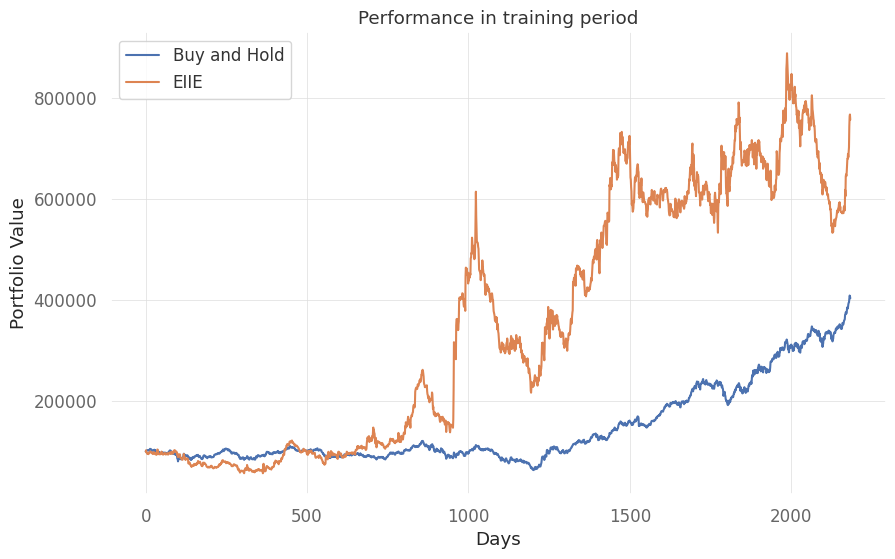

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

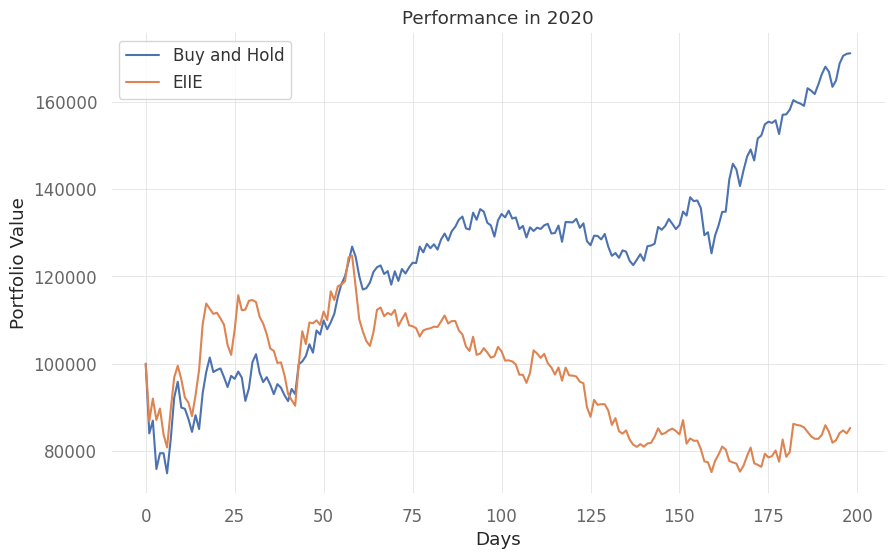

In [20]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

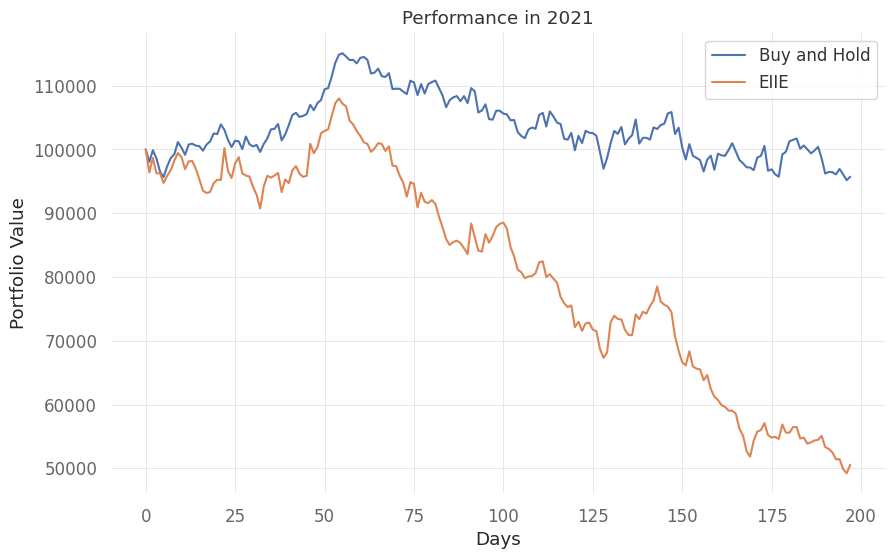

In [21]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

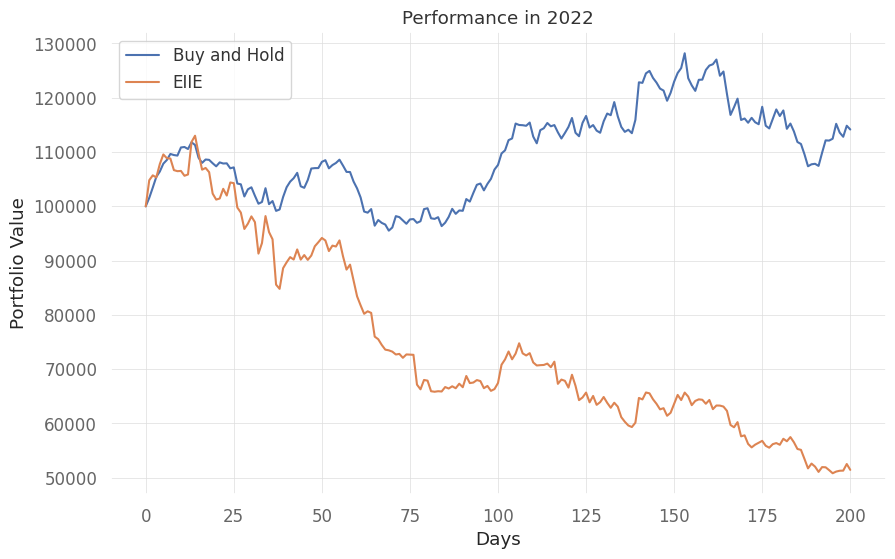

In [22]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is clearly overfitting, since it achieves great results in training period but is mediocre in testing periods. This is a common problem in this policy gradient algorithm. To deal with this, you can change the hyperparameters.